# Indoor Fingerprinting Localization based on Deep Learning

In [1]:
#Jait Purohit

import sklearn.feature_extraction.text as sk_text
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from pandas import Series
%matplotlib inline
import json
import csv
import pandas as pd
import keras
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Conv1D, MaxPooling1D
import time
import seaborn as sns
sns.set_style('whitegrid')
import numpy as np
from sklearn.svm import SVC
from sklearn.calibration import CalibratedClassifierCV
import time
import numpy as np
import pandas as pd
from scipy import stats
import statsmodels
import matplotlib.pyplot as plt
import matplotlib
import pickle
import math
import pandas as pd
import numpy as np
from sklearn.preprocessing import Imputer
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import precision_score, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt

%matplotlib inline

from sklearn.model_selection import train_test_split

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import seaborn as sns

Using TensorFlow backend.


In [0]:
import collections
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shutil
import os
from sklearn.metrics import roc_curve, auc

# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)


# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)


# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column. 
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, collections.Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)


# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)


# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
               * (normalized_high - normalized_low) + normalized_low


In [3]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')
# 4/nQGR-xdp25F2tuLBwf1kKyjtJk-HJX5C0wYX_DV2soGrEWSo-HwfH6k

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
pip install geopandas

     |████████████████████████████████| 921kB 3.4MB/s 
     |████████████████████████████████| 10.1MB 43.8MB/s 
     |████████████████████████████████| 11.9MB 39.3MB/s 
  Created wheel for munch: filename=munch-2.3.2-py2.py3-none-any.whl size=6614 sha256=c4f97dcb15c7fb1f9b21f1b0d2b7e5bf6f3da503ec96db830334c296211f4a4e
  Stored in directory: /root/.cache/pip/wheels/db/bf/bc/06a3e1bfe0ab27d2e720ceb3cff3159398d92644c0cec2c125
Successfully built munch


In [0]:
# Load all importance packages
import geopandas
import numpy as np
import pandas as pd
from shapely.geometry import Point

import missingno as msn

import seaborn as sns
import matplotlib.pyplot as plt

## Deep Learning Algorithms to Estimate/Predict Location

In [0]:
prob_ori_df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/masters_project/indoor_rvr_3rd_floor_data copy 2 (1).csv')

In [5]:
prob_ori_df.sample(10)

,'BS 1','BS 2','SF','HDOP',latitude,longitude
50,-75,-70,10,2.789000,-9.0,-2.5
43,-65,-63,10,3.714600,-6.5,-2.5
22,-58,-57,7,1.100000,-2.0,-2.5
57,-79,-77,12,6.246500,-10.0,-2.5
48,-71,-70,9,0.640000,-7.5,-2.5
60,-81,-79,7,4.563200,-11.0,-2.5
61,-83,-79,7,4.563200,-11.0,-2.5
74,-83,-81,10,4.752340,-12.0,-1.5
8,-52,-52,7,1.050000,0.0,-1.0
65,-79,-81,8,5.725311,-12.0,-2.5


In [0]:
prob_df1 = prob_ori_df[["'BS 1'","'BS 2'","'SF'","'HDOP'",'latitude','longitude']]

In [7]:
prob_df1.head()

,'BS 1','BS 2','SF','HDOP',latitude,longitude
0,-49,-51,7,0.6,0.0,0.0
1,-49,-51,7,0.6,0.0,0.0
2,-49,-51,7,0.6,0.0,0.0
3,-49,-50,8,0.6,0.0,0.0
4,-50,-50,8,0.6,0.0,0.0


In [0]:
max = prob_df1["'BS 1'"].max()
min = prob_df1["'BS 1'"].min()
prob_df1['normalized_bs1'] = (prob_df1["'BS 1'"] - min)/(max - min)

In [0]:
max = prob_df1["'BS 2'"].max()
min = prob_df1["'BS 2'"].min()
prob_df1['normalized_bs2'] = (prob_df1["'BS 2'"] - min)/(max - min)

In [0]:
max = prob_df1["'SF'"].max()
min = prob_df1["'SF'"].min()
prob_df1['normalized_sf'] = (prob_df1["'SF'"] - min)/(max - min)

In [0]:
max = prob_df1["'HDOP'"].max()
min = prob_df1["'HDOP'"].min()
prob_df1['normalized_hdop'] = (prob_df1["'HDOP'"] - min)/(max - min)

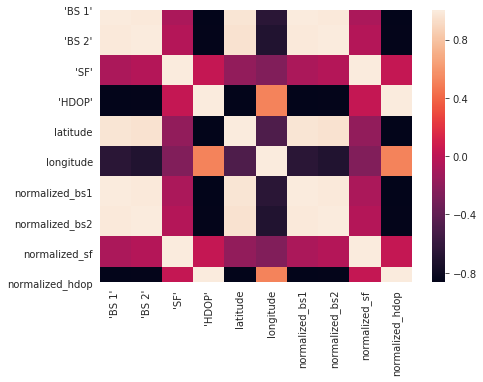

In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(7,5))
sns.heatmap(prob_df1.corr());

In [13]:
prob_df1.head()

,'BS 1','BS 2','SF','HDOP',latitude,longitude,normalized_bs1,normalized_bs2,normalized_sf,normalized_hdop
0,-49,-51,7,0.6,0.0,0.0,1.000000,0.977778,0.166667,0.0
1,-49,-51,7,0.6,0.0,0.0,1.000000,0.977778,0.166667,0.0
2,-49,-51,7,0.6,0.0,0.0,1.000000,0.977778,0.166667,0.0
3,-49,-50,8,0.6,0.0,0.0,1.000000,1.000000,0.333333,0.0
4,-50,-50,8,0.6,0.0,0.0,0.978261,1.000000,0.333333,0.0


In [0]:
encode_numeric_zscore(prob_df1, 'latitude', mean=None, sd=None)

In [0]:
encode_numeric_zscore(prob_df1, 'longitude', mean=None, sd=None)

In [16]:
traincols = prob_df1.columns.tolist() 
traincols.remove('latitude')
traincols.remove('longitude')
#traincols.remove('normalized_latitude')
#traincols.remove('normalized_longitude')
traincols.remove("'BS 1'")
traincols.remove("'BS 2'")
traincols.remove("'SF'")
traincols.remove("'HDOP'")
#traincols.remove('distance')
len(traincols)

4

In [17]:
traincols

['normalized_bs1', 'normalized_bs2', 'normalized_sf', 'normalized_hdop']

In [0]:
columns_X = traincols
x = prob_df1[columns_X]
columns_y = ['latitude','longitude']
y = prob_df1[columns_y]

In [19]:
x.head()

,normalized_bs1,normalized_bs2,normalized_sf,normalized_hdop
0,1.000000,0.977778,0.166667,0.0
1,1.000000,0.977778,0.166667,0.0
2,1.000000,0.977778,0.166667,0.0
3,1.000000,1.000000,0.333333,0.0
4,0.978261,1.000000,0.333333,0.0


In [20]:
y.head(10)

,latitude,longitude
0,1.563657,0.244479
1,1.563657,0.244479
2,1.563657,0.244479
3,1.563657,0.244479
4,1.563657,0.244479
5,1.563657,-0.122240
6,1.563657,-0.122240
7,1.563657,-0.122240
8,1.563657,-0.122240
9,1.563657,-0.122240


In [0]:
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [0]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import confusion_matrix
def print_report(y_pred,y_true):
    print("Accuracy: ", metrics.accuracy_score(y_true,y_pred))
    print("Precision: ", metrics.precision_score(y_true,y_pred, pos_label=1, average='weighted'))
    print("Recall: ", metrics.recall_score(y_true,y_pred, pos_label=1, average='weighted'))
    print("F1_Score: ", metrics.f1_score(y_true,y_pred, pos_label=1, average='weighted'))
    cm = confusion_matrix(y_true, y_pred)
    print(cm)
    outcome = encode_text_index(prob_df1,'longitude','latitude')
    print('Plotting confusion matrix')
    plt.figure()
    plot_confusion_matrix(cm, outcome)
    plt.show()
    print(classification_report(y_true, y_pred))

In [23]:
prob_df1.shape

(105, 10)

In [24]:
prob_df1.head()

,'BS 1','BS 2','SF','HDOP',latitude,longitude,normalized_bs1,normalized_bs2,normalized_sf,normalized_hdop
0,-49,-51,7,0.6,1.563657,0.244479,1.000000,0.977778,0.166667,0.0
1,-49,-51,7,0.6,1.563657,0.244479,1.000000,0.977778,0.166667,0.0
2,-49,-51,7,0.6,1.563657,0.244479,1.000000,0.977778,0.166667,0.0
3,-49,-50,8,0.6,1.563657,0.244479,1.000000,1.000000,0.333333,0.0
4,-50,-50,8,0.6,1.563657,0.244479,0.978261,1.000000,0.333333,0.0


In [0]:
import seaborn as sns
%matplotlib inline

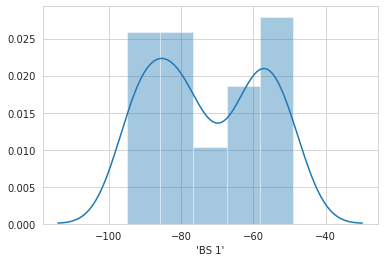

In [26]:
sns.distplot(prob_df1["'BS 1'"])

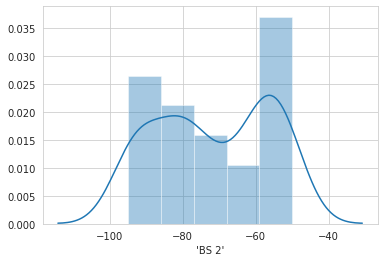

In [27]:
sns.distplot(prob_df1["'BS 2'"])

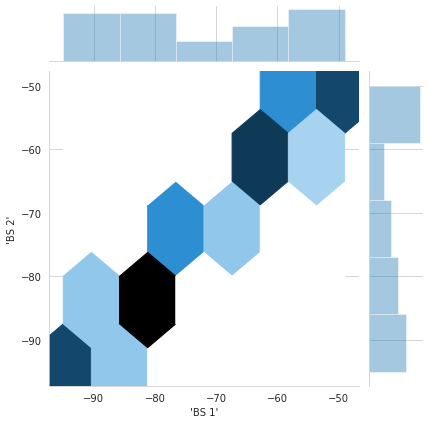

In [28]:
sns.jointplot(x="'BS 1'", y="'BS 2'", data = prob_df1, kind = 'hex')

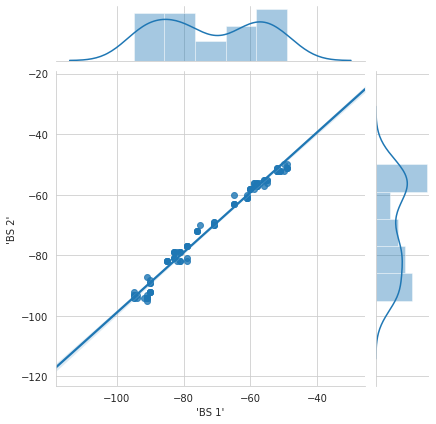

In [29]:
sns.jointplot(x="'BS 1'", y="'BS 2'", data = prob_df1, kind = 'reg')

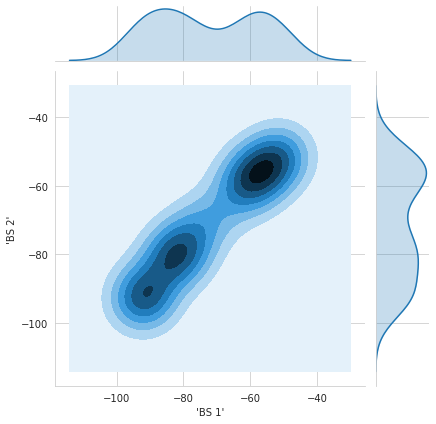

In [30]:
sns.jointplot(x="'BS 1'", y="'BS 2'", data = prob_df1, kind = 'kde')

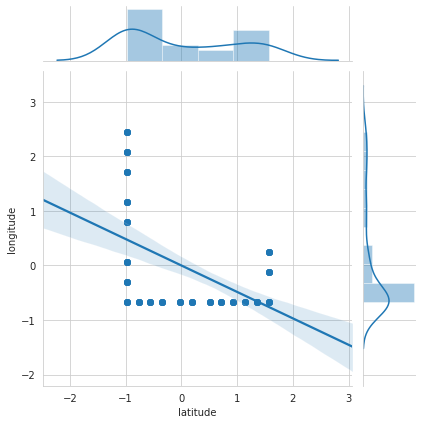

In [31]:
sns.jointplot(x='latitude', y='longitude', data = prob_df1, kind = 'reg')

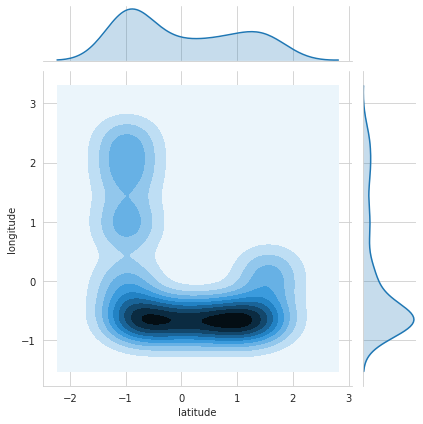

In [32]:
sns.jointplot(x='latitude', y='longitude', data = prob_df1, kind = 'kde')

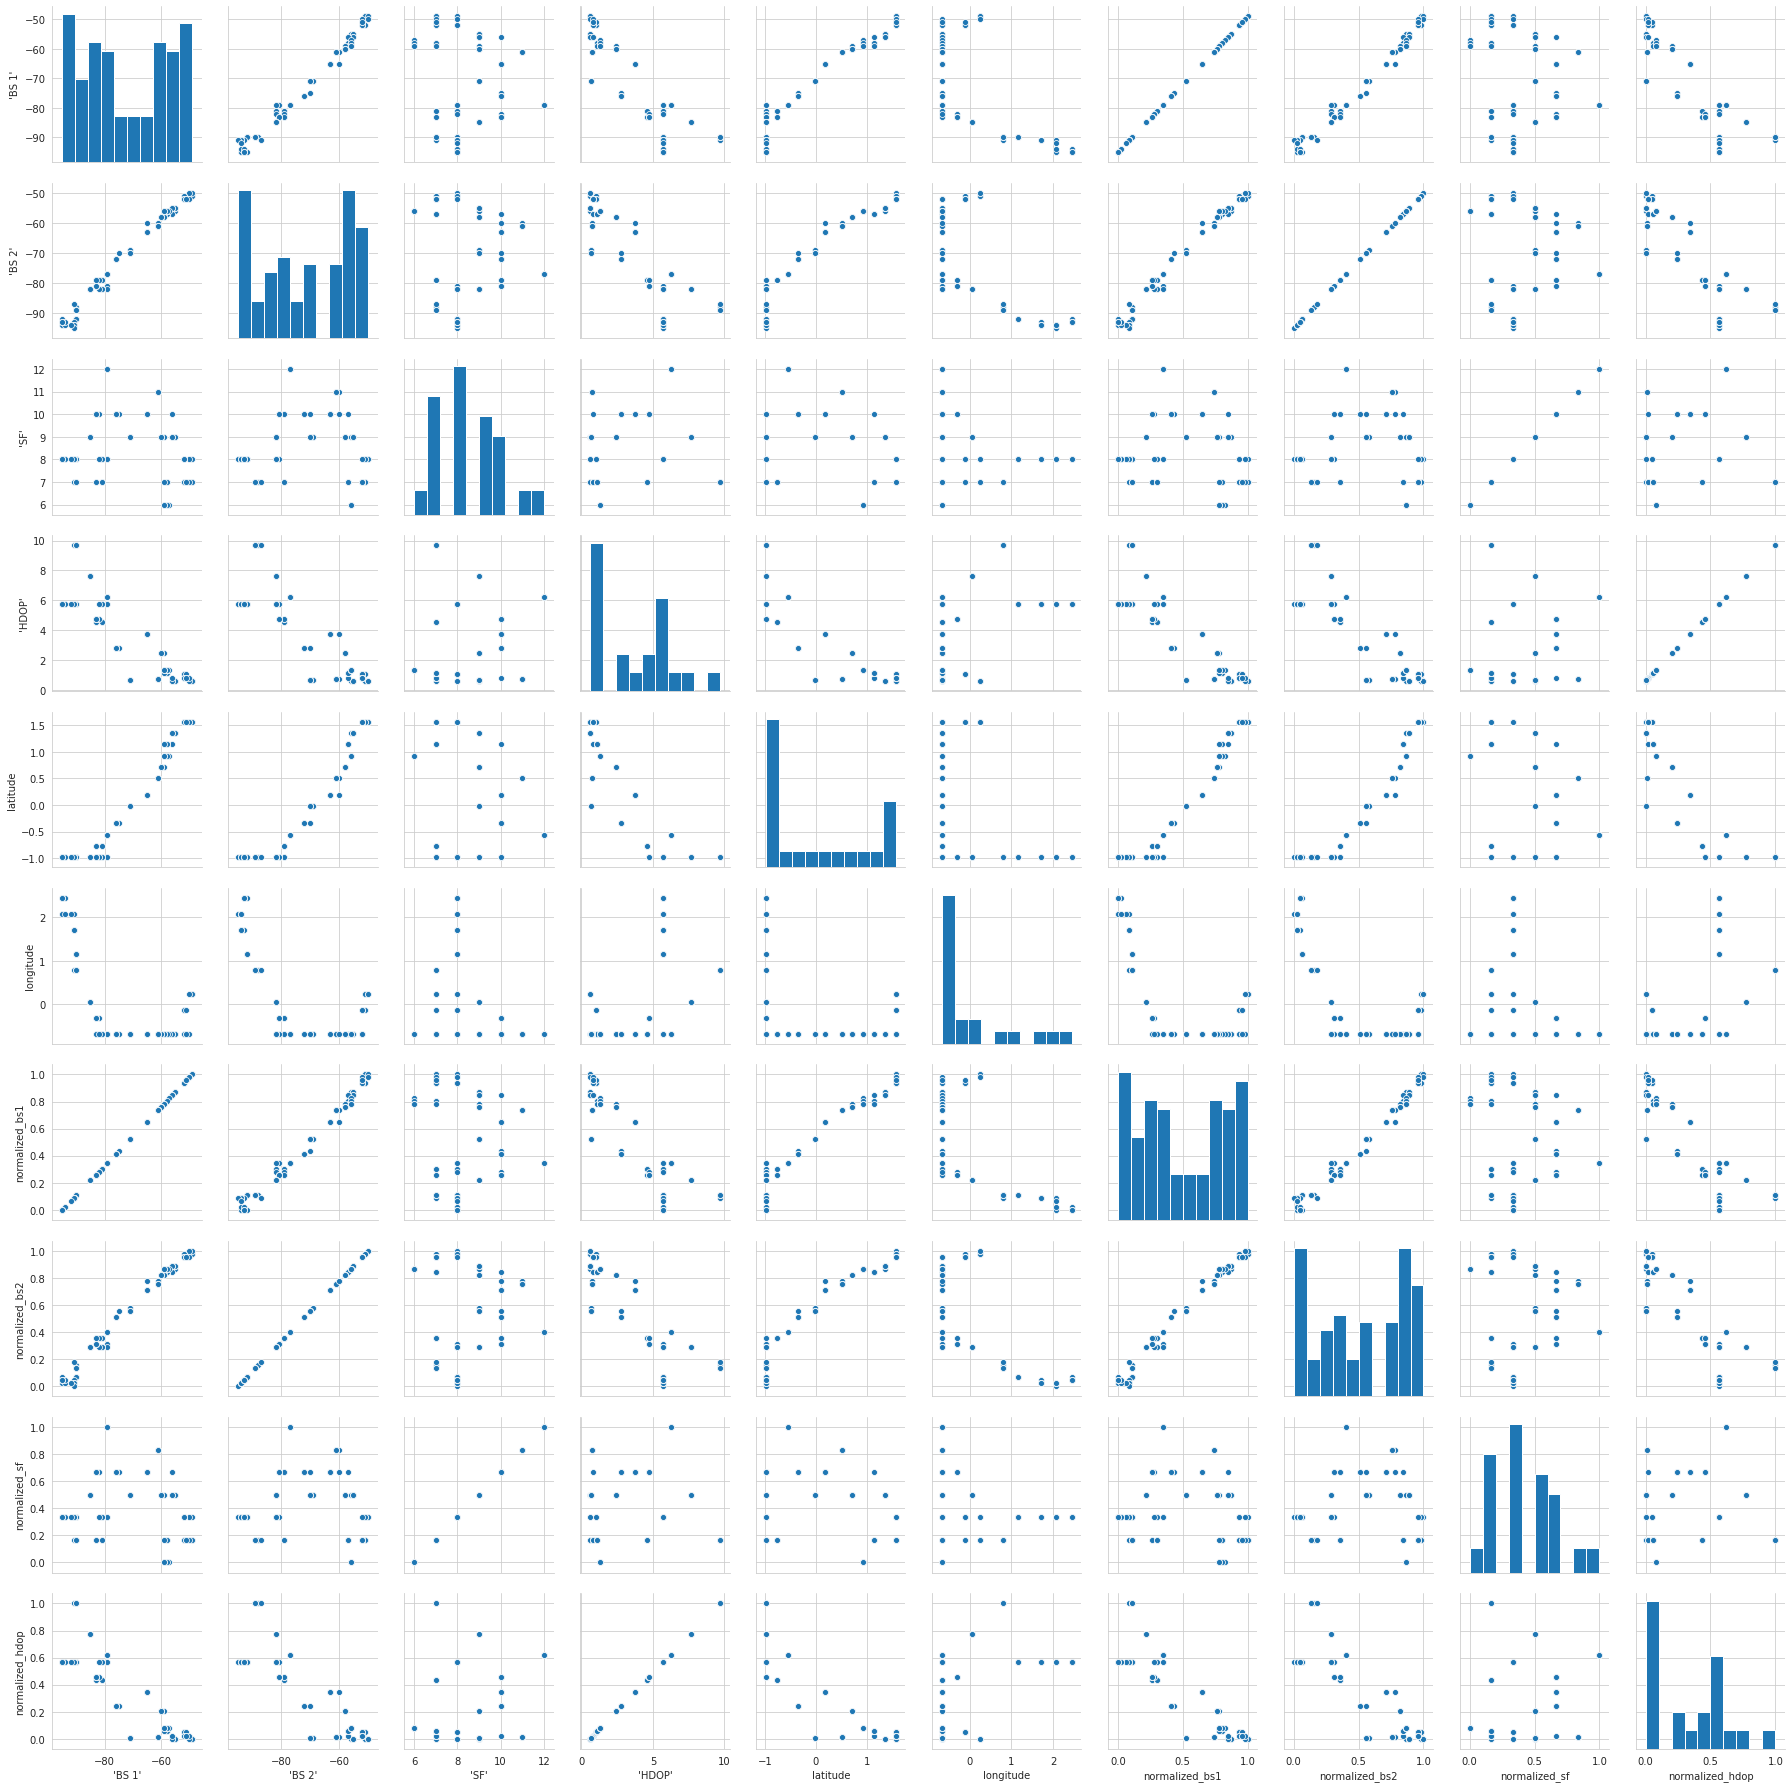

In [33]:
# Pairplot of all numerical value
sns.pairplot(prob_df1)

In [0]:
x_train, x_test, y_train, y_test = train_test_split(prob_df1[traincols],prob_df1[columns_y], test_size=0.3, random_state=42)

## Artificial Neural Network

In [35]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
import os
import io
import requests
from sklearn import metrics


x_train_ann_class, x_test_ann_class, y_train_ann_class, y_test_ann_class = train_test_split(x,y, test_size=0.25, random_state=42)
checkpointer = ModelCheckpoint(filepath="/content/drive/My Drive/Colab Notebooks/masters_project/best_weights_fairclass.hdf5", verbose=0, save_best_only=True) # save best model

for i in range(5):
    model = Sequential()
    model.add(Dense(60, input_dim=x.shape[1], activation='softmax')) # Hidden 1
    model.add(Dense(30, activation='softmax')) # Hidden 2
    model.add(Dense(15, activation='softmax')) # Hidden 3
    model.add(Dense(2)) # Output
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
    history = model.fit(x_train_ann_class, y_train_ann_class, validation_data=(x_test_ann_class,y_test_ann_class), callbacks=[monitor,checkpointer], verbose=0, epochs=10, batch_size=256)  

    

model.load_weights('/content/drive/My Drive/Colab Notebooks/masters_project/best_weights_fairclass.hdf5')
pred = model.predict(x_test_ann_class)














Epoch 00006: early stopping


In [36]:
print(pred)

[[ 0.07661489 -0.06261185]
 [ 0.07662616 -0.06261363]
 [ 0.07662237 -0.0626118 ]
 [ 0.07662587 -0.06262001]
 [ 0.07662015 -0.06261827]
 [ 0.07663273 -0.06261794]
 [ 0.07663289 -0.06261794]
 [ 0.07662053 -0.06261856]
 [ 0.07660539 -0.06260537]
 [ 0.0766043  -0.06260499]
 [ 0.07661217 -0.06261277]
 [ 0.07661507 -0.06261194]
 [ 0.07663185 -0.06261736]
 [ 0.07663289 -0.06261799]
 [ 0.07663105 -0.06261481]
 [ 0.07660667 -0.06260766]
 [ 0.07663056 -0.06260885]
 [ 0.07661507 -0.06261194]
 [ 0.07660519 -0.06260529]
 [ 0.07660551 -0.06260363]
 [ 0.07663315 -0.06261814]
 [ 0.07663489 -0.06262299]
 [ 0.07660843 -0.06260721]
 [ 0.07663105 -0.06261481]
 [ 0.07662101 -0.06261527]
 [ 0.07663137 -0.06262067]
 [ 0.07661235 -0.06261298]]


In [37]:
y_test_ann_class

,latitude,longitude
30,0.716256,-0.672318
65,-0.978547,-0.672318
64,-0.766696,-0.672318
53,-0.342996,-0.672318
45,-0.025220,-0.672318
94,-0.978547,1.711355
104,-0.978547,2.444793
47,-0.025220,-0.672318
10,1.563657,-0.672318
0,1.563657,0.244479


In [0]:
list_1 = []
for p in range(len(pred)):
  sum = pred[p][0]
  list_1.append(sum)

In [0]:
list_2 = []
for l in range(len(pred)):
  sum1 = pred[l][1]
  list_2.append(sum1)

In [40]:
y_test_ann_class['pred_latitude'] = list_1
y_test_ann_class['pred_longitude'] = list_2
y_test_ann_class

,latitude,longitude,pred_latitude,pred_longitude
30,0.716256,-0.672318,0.076615,-0.062612
65,-0.978547,-0.672318,0.076626,-0.062614
64,-0.766696,-0.672318,0.076622,-0.062612
53,-0.342996,-0.672318,0.076626,-0.062620
45,-0.025220,-0.672318,0.076620,-0.062618
94,-0.978547,1.711355,0.076633,-0.062618
104,-0.978547,2.444793,0.076633,-0.062618
47,-0.025220,-0.672318,0.076621,-0.062619
10,1.563657,-0.672318,0.076605,-0.062605
0,1.563657,0.244479,0.076604,-0.062605


In [0]:
y_test_ann_class['error'] = (((y_test_ann_class.latitude.sub(y_test_ann_class['pred_latitude']).pow(2).
                              add(y_test_ann_class.longitude.sub(y_test_ann_class['pred_longitude']).pow(2))).pow(.5)))        

In [44]:
y_test_ann_class

,latitude,longitude,pred_latitude,pred_longitude,error
30,0.716256,-0.672318,0.076615,-0.062612,0.883675
65,-0.978547,-0.672318,0.076626,-0.062614,1.218659
64,-0.766696,-0.672318,0.076622,-0.062612,1.040638
53,-0.342996,-0.672318,0.076626,-0.062620,0.740145
45,-0.025220,-0.672318,0.076620,-0.062618,0.618147
94,-0.978547,1.711355,0.076633,-0.062618,2.064070
104,-0.978547,2.444793,0.076633,-0.062618,2.720388
47,-0.025220,-0.672318,0.076621,-0.062619,0.618146
10,1.563657,-0.672318,0.076605,-0.062605,1.607194
0,1.563657,0.244479,0.076604,-0.062605,1.518429


In [45]:
ann_mean_error = y_test_ann_class['error'].mean()
ann_mean_error

1.3139261450673037

## LSTM

In [46]:
prob_df1.head()

,'BS 1','BS 2','SF','HDOP',latitude,longitude,normalized_bs1,normalized_bs2,normalized_sf,normalized_hdop
0,-49,-51,7,0.6,1.563657,0.244479,1.000000,0.977778,0.166667,0.0
1,-49,-51,7,0.6,1.563657,0.244479,1.000000,0.977778,0.166667,0.0
2,-49,-51,7,0.6,1.563657,0.244479,1.000000,0.977778,0.166667,0.0
3,-49,-50,8,0.6,1.563657,0.244479,1.000000,1.000000,0.333333,0.0
4,-50,-50,8,0.6,1.563657,0.244479,0.978261,1.000000,0.333333,0.0


In [0]:
prob_df_lstm = prob_df1[['normalized_bs1','normalized_bs2','normalized_sf','normalized_hdop','latitude','longitude']]

In [0]:
xarray=[]
xarray=prob_df_lstm.as_matrix()

In [49]:
xarray

array([[ 1.00000000e+00,  9.77777778e-01,  1.66666667e-01,
         0.00000000e+00,  1.56365707e+00,  2.44479273e-01],
       [ 1.00000000e+00,  9.77777778e-01,  1.66666667e-01,
         0.00000000e+00,  1.56365707e+00,  2.44479273e-01],
       [ 1.00000000e+00,  9.77777778e-01,  1.66666667e-01,
         0.00000000e+00,  1.56365707e+00,  2.44479273e-01],
       [ 1.00000000e+00,  1.00000000e+00,  3.33333333e-01,
         0.00000000e+00,  1.56365707e+00,  2.44479273e-01],
       [ 9.78260870e-01,  1.00000000e+00,  3.33333333e-01,
         0.00000000e+00,  1.56365707e+00,  2.44479273e-01],
       [ 9.34782609e-01,  9.77777778e-01,  3.33333333e-01,
         4.95742101e-02,  1.56365707e+00, -1.22239637e-01],
       [ 9.34782609e-01,  9.77777778e-01,  3.33333333e-01,
         4.95742101e-02,  1.56365707e+00, -1.22239637e-01],
       [ 9.34782609e-01,  9.55555556e-01,  3.33333333e-01,
         4.95742101e-02,  1.56365707e+00, -1.22239637e-01],
       [ 9.34782609e-01,  9.55555556e-01,  1.666

In [0]:
yarray=prob_df1[['latitude','longitude']].as_matrix()

In [0]:
SEQUENCE_SIZE = 1
import numpy as np

def to_sequences(seq_size, data,data2):
    x = []
    y = []

    for i in range(len(data)-SEQUENCE_SIZE-1):
        #print(i)
        window = data[i:(i+SEQUENCE_SIZE)]
        after_window = data2[i+SEQUENCE_SIZE]
        window = [[x] for x in window]
        #print("{} - {}".format(window,after_window))
        x.append(window)
        y.append(after_window)
        
    return np.array(x),np.array(y)

In [0]:
x,y = to_sequences(SEQUENCE_SIZE,xarray,yarray)

In [53]:
x.shape

(103, 1, 1, 6)

In [54]:
y.shape

(103, 2)

In [0]:
x_rnn = x.reshape(x.shape[0],1,6)

In [0]:
y_rnn = y.reshape(y.shape[0], 2)

In [57]:
x_rnn.shape

(103, 1, 6)

In [58]:
y_rnn.shape

(103, 2)

In [0]:
x_train_lstm = x_rnn[0:75]
y_train_lstm = y_rnn[0:75]
x_test_lstm = x_rnn[75:103]
y_test_lstm = y_rnn[75:103]

In [60]:
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from keras.datasets import imdb
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
import numpy as np

# x_train_lstm, y_train_lstm, x_test_lstm, y_test_lstm = train_test_split(x_rnn,y_rnn, test_size=0.3, random_state=42)
checkpointer = ModelCheckpoint(filepath="/content/drive/My Drive/Colab Notebooks/masters_project/best_weights_fairclass1.hdf5", verbose=0, save_best_only=True) # save best model

print('Build model...')
for i in range(5):
    model = Sequential()
    model.add(LSTM(512, dropout=0.1, recurrent_dropout=0.1, input_shape=(1, 6)))
    model.add(Dense(256))
    model.add(Dense(128))
    model.add(Dense(2))
    model.summary()
    model.compile(loss='mean_squared_error', optimizer='adam')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
    print('Train...')
    model.fit(x_train_lstm,y_train_lstm,validation_data=(x_test_lstm,y_test_lstm),callbacks=[monitor,checkpointer],verbose=2, epochs=10, batch_size = 512)
     
model.load_weights('/content/drive/My Drive/Colab Notebooks/masters_project/best_weights_fairclass1.hdf5')
pred = model.predict(x_test_lstm)

Build model...

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 512)               1062912   
_________________________________________________________________
dense_21 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_22 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_23 (Dense)             (None, 2)                 258       
Total params: 1,227,394
Trainable params: 1,227,394
Non-trainable params: 0
_________________________________________________________________
Train...
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on

In [0]:
list_1 = []
for p in range(len(pred)):
  sum = pred[p][0]
  list_1.append(sum)
list_2 = []
for l in range(len(pred)):
  sum1 = pred[l][1]
  list_2.append(sum1)


In [0]:
pred_lstm_lat = pd.DataFrame(list_1, columns =['pred_latitude'])
pred_lstm_long = pd.DataFrame(list_2, columns =['pred_longitude'])

In [63]:
pred_lstm_lat.head()

,pred_latitude
0,-0.699046
1,-0.699046
2,-0.699046
3,-0.699046
4,-0.699046


In [64]:
pred_lstm_long.head()

,pred_longitude
0,-0.449927
1,-0.449927
2,-0.449927
3,-0.449927
4,-0.449927


In [0]:
list_1 = []
for p in range(len(y_test_lstm)):
  sum = y_test_lstm[p][0]
  list_1.append(sum)
list_2 = []
for l in range(len(y_test_lstm)):
  sum1 = y_test_lstm[l][1]
  list_2.append(sum1)

In [0]:
y_test_lstm_lat = pd.DataFrame(list_1, columns =['pred_latitude'])
y_test_lstm_long = pd.DataFrame(list_2, columns =['pred_longitude'])

In [67]:
y_test_lstm_lat.head()

,pred_latitude
0,-0.978547
1,-0.978547
2,-0.978547
3,-0.978547
4,-0.978547


In [68]:
y_test_lstm_long.head()

,pred_longitude
0,0.061120
1,0.061120
2,0.061120
3,0.061120
4,0.794558


In [69]:
y_test_lstm = (((y_test_lstm_lat.pred_latitude.sub(pred_lstm_lat['pred_latitude']).pow(2).
                              add(y_test_lstm_long.pred_longitude.sub(pred_lstm_long['pred_longitude']).pow(2))).pow(.5)))
y_test_lstm_1 = y_test_lstm
lstm_score = y_test_lstm.mean()
lstm_score

1.4568874550947268

In [0]:
y_test_lstm_1 = y_test_lstm_1.to_frame()

In [71]:
y_test_lstm_1

,0
0,0.582486
1,0.582486
2,0.582486
3,0.582486
4,1.275485
5,1.007845
6,1.008131
7,1.002769
8,1.002769
9,1.360877


## CNN

In [0]:
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from keras.datasets import imdb
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
import numpy as np

In [73]:
prob_df1.head()

,'BS 1','BS 2','SF','HDOP',latitude,longitude,normalized_bs1,normalized_bs2,normalized_sf,normalized_hdop
0,-49,-51,7,0.6,1.563657,0.244479,1.000000,0.977778,0.166667,0.0
1,-49,-51,7,0.6,1.563657,0.244479,1.000000,0.977778,0.166667,0.0
2,-49,-51,7,0.6,1.563657,0.244479,1.000000,0.977778,0.166667,0.0
3,-49,-50,8,0.6,1.563657,0.244479,1.000000,1.000000,0.333333,0.0
4,-50,-50,8,0.6,1.563657,0.244479,0.978261,1.000000,0.333333,0.0


In [0]:
prob_df_cnn = prob_df1[['normalized_bs1','normalized_bs2','normalized_sf','normalized_hdop','latitude','longitude']]

In [0]:
xarray=[]
xarray=prob_df_cnn.as_matrix()

In [0]:
yarray=prob_df1[['latitude','longitude']].as_matrix()

In [0]:
SEQUENCE_SIZE = 1
import numpy as np

def to_sequences(seq_size, data,data2):
    x = []
    y = []

    for i in range(len(data)-SEQUENCE_SIZE-1):
        #print(i)
        window = data[i:(i+SEQUENCE_SIZE)]
        after_window = data2[i+SEQUENCE_SIZE]
        window = [[x] for x in window]
        #print("{} - {}".format(window,after_window))
        x.append(window)
        y.append(after_window)
        
    return np.array(x),np.array(y)

In [0]:
x,y = to_sequences(SEQUENCE_SIZE,xarray,yarray)

In [0]:
x_cnn = x.reshape(x.shape[0], 1, 1, 6)
y_cnn = y.reshape(y.shape[0], 2)

In [0]:
x_train_cnn = x_cnn[0:75]
y_train_cnn = y_cnn[0:75]
x_test_cnn = x_cnn[75:103]
y_test_cnn = y_cnn[75:103]

In [81]:
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
batch_size = 64

import numpy as np
import h5py

f = h5py.File('/content/drive/My Drive/Colab Notebooks/masters_project/best_weights_fairclass2.hdf5','w')
group = f.create_group('a_group')
f.close()

checkpointer = ModelCheckpoint(filepath="/content/drive/My Drive/Colab Notebooks/masters_project/best_weights_fairclass2.hdf5", verbose=0, save_best_only=True) # save best model

for i in range(2):
    model = Sequential()
    input_shape = (1, 1, 6)
    model.add(Conv2D(1024, kernel_size=(3, 3), strides=(1, 1), padding='same',activation='relu',input_shape=input_shape)) 
    model.add(MaxPooling2D(pool_size=(2,2),padding='same'))
    model.add(Conv2D(512, (3, 3), padding='same', activation='tanh'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=None,padding='same'))
    #model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2))
    model.summary()
    model.compile(loss="mean_squared_error", optimizer="adam")
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience =5, verbose=2, mode='auto')
    model.fit(x_train_cnn, y_train_cnn,batch_size=batch_size,epochs=3,verbose=1,validation_data=(x_test_cnn, y_test_cnn),callbacks=[monitor,checkpointer])

model.load_weights('/content/drive/My Drive/Colab Notebooks/masters_project/best_weights_fairclass2.hdf5')
pred = model.predict(x_test_cnn)


Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 1, 1, 1024)        56320     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 1, 1, 1024)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 1, 1, 512)         4719104   
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 1, 1, 512)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_36 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)            

In [82]:
list_1 = []
for p in range(len(pred)):
  sum = pred[p][0]
  list_1.append(sum)
list_2 = []
for l in range(len(pred)):
  sum1 = pred[l][1]
  list_2.append(sum1)
pred_cnn_lat = pd.DataFrame(list_1, columns =['pred_latitude'])
pred_cnn_long = pd.DataFrame(list_2, columns =['pred_longitude'])
list_1 = []
for p in range(len(y_test_cnn)):
  sum = y_test_cnn[p][0]
  list_1.append(sum)
list_2 = []
for l in range(len(y_test_cnn)):
  sum1 = y_test_cnn[l][1]
  list_2.append(sum1)
y_test_cnn_lat = pd.DataFrame(list_1, columns =['pred_latitude'])
y_test_cnn_long = pd.DataFrame(list_2, columns =['pred_longitude'])

y_test_cnn = (((y_test_cnn_lat.pred_latitude.sub(pred_cnn_lat['pred_latitude']).pow(2).
                              add(y_test_cnn_long.pred_longitude.sub(pred_cnn_long['pred_longitude']).pow(2))).pow(.5)))
y_test_cnn_1 = y_test_cnn
cnn_score_1 = y_test_cnn.mean()
cnn_score_1

1.8292749193713551

In [0]:
y_test_cnn_1 = y_test_cnn_1.to_frame()

In [84]:
y_test_cnn_1

,0
0,0.940091
1,0.940091
2,0.940091
3,0.940091
4,1.320425
5,1.298111
6,1.298214
7,1.297013
8,1.297013
9,1.577531


# Indoor Results (RVR 3rd Floor, CSUS)

## Tabular Results

**Indoor Localization using Deep Learning Techniques**

In [0]:
# initialise data of lists. 
data = {'Classifier':['ANN', 'LSTM','CNN'],'Error_Difference':[ann_mean_error, lstm_score, cnn_score_1], 'GPU_Run_Time':['65','79','82'], 'TPU_Run_Time':['63','76','83'], 
        'Neurons Count': ['60,30,15','512,256,128','1024,512,256'],'Activation_Function': ["softmax","sigmoid","relu,tanh"], 'Optimizer': ["adam","adam","adam"], 'Hidden_Layers': ['3','3','3'], 'Dropout_Layers': ['','0.1','0.5']} 
  
# Creates pandas DataFrame. 
results_matrix_indoor = pd.DataFrame(data, index =['1', '2', '3'])
  

In [0]:
results_matrix_indoor

,Classifier,Error_Difference,GPU_Run_Time,TPU_Run_Time,Neurons Count,Activation_Function,Optimizer,Hidden_Layers,Dropout_Layers
1,ANN,1.324271,65,63,"60,30,15",softmax,adam,3,
2,LSTM,1.409174,79,76,"512,256,128",sigmoid,adam,3,0.1
3,CNN,1.804363,82,83,"1024,512,256","relu,tanh",adam,3,0.5


## Comparison with hyperparameter-tuning Results (ANN)

In [0]:
# initialise data of lists. 
data = {'Classifier':['ANN_Original','Hyperparameter_ANN_1','Hyperparameter_ANN_2'],'Error_Difference':[ann_mean_error, ann_hypertune_1,ann_hypertune_2], 'GPU_Run_Time':['65','71','72'], 'TPU_Run_Time':['63','68','71'], 
        'Neurons Count': ['60,30,15','15,10,5','45,30,15'],'Activation_Function': ["softmax","sigmoid","sigmoid"], 'Optimizer': ["Adam","Adam","RMSprop"], 'Hidden_Layers': ['3','3','3'], 'Batch_Size':['256','512','256'],'Dropout_Layer':['-','-','-'],'Recurrent_Dropout':['-','-','-'],'Kernel_Size':['-','-','-'],'Strides':['-','-','-'],'Pool_Size':['-','-','-']} 
  
# Creates pandas DataFrame. 
results_matrix_ann = pd.DataFrame(data, index =['1', '2', '3'])
  

In [0]:
results_matrix_ann

,Classifier,Error_Difference,GPU_Run_Time,TPU_Run_Time,Neurons Count,Activation_Function,Optimizer,Hidden_Layers,Batch_Size,Dropout_Layer,Recurrent_Dropout,Kernel_Size,Strides,Pool_Size
1,ANN_Original,1.324271,65,63,"60,30,15",softmax,Adam,3,-,-,-,-,-,-
2,Hyperparameter_ANN_1,1.270332,71,68,"15,10,5",sigmoid,Adam,3,-,-,-,-,-,-
3,Hyperparameter_ANN_2,1.286759,72,71,"45,30,15",sigmoid,RMSprop,3,-,-,-,-,-,-


## Comparison with hyperparameter-tuning Results (LSTM)

In [0]:
# initialise data of lists. 
data = {'Classifier':['LSTM_Original','Hyperparameter_LSTM_1','Hyperparameter_LSTM_2'],'Error_Difference':[lstm_score,lstm_score_2,lstm_score_3], 'GPU_Run_Time':['66','67','71'], 'TPU_Run_Time':['71','70','66'], 
        'Neurons Count': ['512,256,128','1024,512,216','1024,512,216'],'Activation_Function': ["Relu","Sigmoid","Sigmoid"],'Optimizer': ["Adam","RMSProp","SGD"], 'Hidden_Layers': ['3','3','3'], 'Batch_Size':['512','81','256'],'Dropout_Layer':['0.1','0.5','0.3'],'Recurrent_Dropout':['0.1','0.1','0.1'],'Kernel_Size':['-','-','-'],'Strides':['-','-','-'],'Pool_Size':['-','-','-']} 
  
# Creates pandas DataFrame. 
results_matrix_lstm = pd.DataFrame(data, index =['1', '2','3'])
  

In [0]:
results_matrix_lstm

,Classifier,Error_Difference,GPU_Run_Time,TPU_Run_Time,Neurons Count,Activation_Function,Optimizer,Hidden_Layers,Batch_Size,Dropout_Layer,Recurrent_Dropout,Kernel_Size,Strides,Pool_Size
1,LSTM_Original,1.409174,66,71,"512,256,128",Relu,Adam,3,512,0.1,0.1,-,-,-
2,Hyperparameter_LSTM_1,1.348190,67,70,"1024,512,216",Sigmoid,RMSProp,3,81,0.5,0.1,-,-,-
3,Hyperparameter_LSTM_2,1.799690,71,66,"1024,512,216",Sigmoid,SGD,3,256,0.3,0.1,-,-,-


## Comparison with hyperparameter-tuning Results (CNN)

In [0]:
# initialise data of lists. 
data = {'Classifier':['CNN_Original','Hyperparameter_CNN_1','Hyperparameter_CNN_2'],'Error_Difference':[cnn_score_1,cnn_score_2,cnn_score_3], 'GPU_Run_Time':['68','71','63'], 'TPU_Run_Time':['62','64','66'], 'Neurons Count': ['1024,512,256','512,256,128','64,128,512'], 'Hidden_Layers': ['3','3','3'],
        'Activation_Function': ["Relu, Tanh","Tanh, Sigmoid","Tanh, Tanh"], 'Optimizer': ["Adam","Adam","SGD"], 'Dropout_Layer': ['0.1','0.5','0.5'],'Recurrent_Dropout':['-','-','-'],'Batch_Size':['64','81','128'],'Kernel_Size':['(3,3)','(3,3)','(3,3)'],'Strides':['(1,1)','(1,1)','(1,1)'],'Pool_Size':['(2,2)','(2,2)','(2,2)']} 
  
# Creates pandas DataFrame. 
results_matrix_cnn = pd.DataFrame(data, index =['1', '2', '3'])
  

In [0]:
results_matrix_cnn

,Classifier,Error_Difference,GPU_Run_Time,TPU_Run_Time,Neurons Count,Hidden_Layers,Activation_Function,Optimizer,Dropout_Layer,Recurrent_Dropout,Batch_Size,Kernel_Size,Strides,Pool_Size
1,CNN_Original,1.804363,68,62,"1024,512,256",3,"Relu, Tanh",Adam,0.1,-,64,"(3,3)","(1,1)","(2,2)"
2,Hyperparameter_CNN_1,1.886141,71,64,"512,256,128",3,"Tanh, Sigmoid",Adam,0.5,-,81,"(3,3)","(1,1)","(2,2)"
3,Hyperparameter_CNN_2,1.786397,63,66,"64,128,512",3,"Tanh, Tanh",SGD,0.5,-,128,"(3,3)","(1,1)","(2,2)"


In [0]:
df_final = pd.concat([results_matrix_ann, results_matrix_lstm, results_matrix_cnn],ignore_index=True, sort=False)

In [0]:
df_final

,Classifier,Error_Difference,GPU_Run_Time,TPU_Run_Time,Neurons Count,Activation_Function,Optimizer,Hidden_Layers,Batch_Size,Dropout_Layer,Recurrent_Dropout,Kernel_Size,Strides,Pool_Size
0,ANN_Original,1.324271,65,63,"60,30,15",softmax,Adam,3,-,-,-,-,-,-
1,Hyperparameter_ANN_1,1.270332,71,68,"15,10,5",sigmoid,Adam,3,-,-,-,-,-,-
2,Hyperparameter_ANN_2,1.286759,72,71,"45,30,15",sigmoid,RMSprop,3,-,-,-,-,-,-
3,LSTM_Original,1.409174,66,71,"512,256,128",Relu,Adam,3,512,0.1,0.1,-,-,-
4,Hyperparameter_LSTM_1,1.348190,67,70,"1024,512,216",Sigmoid,RMSProp,3,81,0.5,0.1,-,-,-
5,Hyperparameter_LSTM_2,1.799690,71,66,"1024,512,216",Sigmoid,SGD,3,256,0.3,0.1,-,-,-
6,CNN_Original,1.804363,68,62,"1024,512,256","Relu, Tanh",Adam,3,64,0.1,-,"(3,3)","(1,1)","(2,2)"
7,Hyperparameter_CNN_1,1.886141,71,64,"512,256,128","Tanh, Sigmoid",Adam,3,81,0.5,-,"(3,3)","(1,1)","(2,2)"
8,Hyperparameter_CNN_2,1.786397,63,66,"64,128,512","Tanh, Tanh",SGD,3,128,0.5,-,"(3,3)","(1,1)","(2,2)"


In [0]:
df_final.to_csv(r'/content/drive/My Drive/Colab Notebooks/masters_project/indoor_results.csv')

## Graphical Results

In [0]:
df_final['GPU_Run_Time'] = df_final['GPU_Run_Time'].astype(int)
df_final['TPU_Run_Time'] = df_final['TPU_Run_Time'].astype(int)
df_final['Error_Difference'] = df_final['Error_Difference'].astype(float)
results_matrix_indoor['GPU_Run_Time'] = results_matrix_indoor['GPU_Run_Time'].astype(int)
results_matrix_indoor['TPU_Run_Time'] = results_matrix_indoor['TPU_Run_Time'].astype(int)
results_matrix_indoor['Error_Difference'] = results_matrix_indoor['Error_Difference'].astype(float)

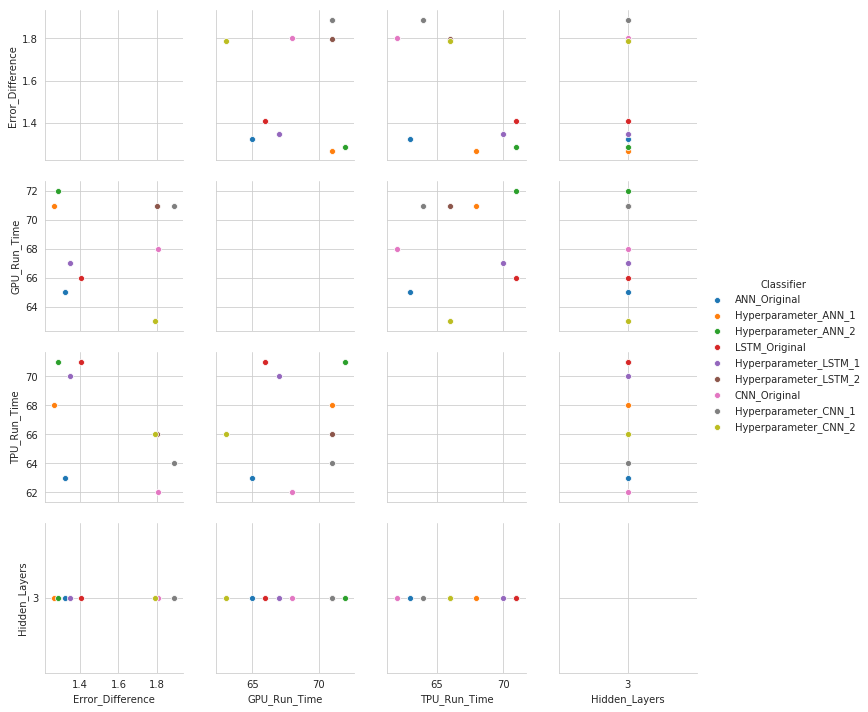

In [0]:
# Pairplot of all numerical value
sns.pairplot(df_final,hue='Classifier')

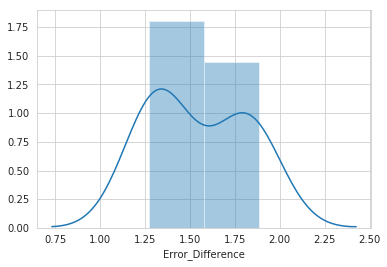

In [0]:
sns.distplot(df_final['Error_Difference'])

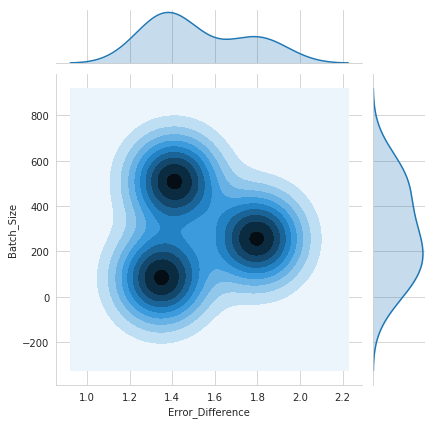

In [0]:
# LSTM error vs batch size
sns.jointplot(x='Error_Difference', y='Batch_Size', data = results_matrix_lstm, kind = 'kde')

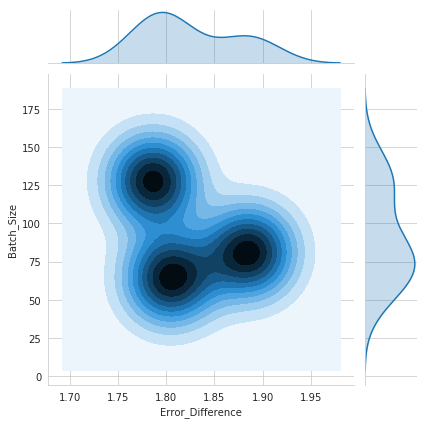

In [0]:
# CNN error vs batch size
sns.jointplot(x='Error_Difference', y='Batch_Size', data = results_matrix_cnn, kind = 'kde')